# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


In [6]:
brain.vector_observation_space_size

37

In [7]:
print(env_info.vector_observations[0])

[ 0.          1.          0.          0.          0.59000909  0.          1.
  0.          0.          0.86335975  1.          0.          0.          0.
  0.02599395  0.          0.          1.          0.          0.15619929
  1.          0.          0.          0.          0.33563313  0.          0.
  1.          0.          0.67392349  0.          1.          0.          0.
  0.89596486  0.          0.        ]


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [8]:
# Importing section

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import random
import numpy as np

from collections import deque, namedtuple

# Device section

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper - parameters

In [10]:
Buffer_size = int (1e5)
Batch_size = 64
Gamma = 0.99
Tau = 1e-3
Update_Every = 4
LR = 5e-4

# Net

In [11]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed , hidden_layer_1 = 256, hidden_layer_2 = 128):
        super(QNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_layer_1 = hidden_layer_1
        self.hidden_layer_2 = hidden_layer_2       
   
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(self.state_size, self.hidden_layer_1)
        self.fc2 = nn.Linear(self.hidden_layer_1, self.hidden_layer_2)
        self.value = nn.Linear(self.hidden_layer_2, self.action_size)
        self.adv = nn.Linear(self.hidden_layer_2, self.action_size)
        
    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        final = self.value(state) + (self.adv(state) - self.adv(state).mean())
        return final

# Buffer

In [12]:
class ReplayBuffer():
    
    def __init__(self, Buffer_dim, Batch_size, seed):
        
        self.Buffer_dim = Buffer_dim
        self.Batch_size = Batch_size
        self.Buffer = deque(maxlen = self.Buffer_dim)
        self.experience = namedtuple('Experience', field_names = ['state', 'action', 'reward', 'next_state', 'is_done'])
        self.seed = seed
        
    def add(self, state, action, reward, next_state, is_done):
        
        e = self.experience(state, action, reward, next_state, is_done)
        self.Buffer.append(e)
        return
    
    def sample(self):
        
        experiences = random.sample(self.Buffer, k = self.Batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float().to(device)
        is_dones = torch.from_numpy(np.vstack([np.float32(exp.is_done) for exp in experiences if exp is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, is_dones)
    
    def __len__(self):
        
        return len(self.Buffer)

# Agent

In [13]:
class Agent():
    
    def __init__(self, state_space_dim, action_space_dim, seed):
        
        self.state_space_dim = state_space_dim
        self.action_space_dim = action_space_dim   
        self.seed = random.seed(seed)
        
        self.memory = ReplayBuffer(Buffer_size, Batch_size, seed)
        self.Q_network = QNetwork(self.state_space_dim, self.action_space_dim, seed).to(device)
        self.Q_network_target = QNetwork(self.state_space_dim, self.action_space_dim, seed).to(device)
        self.optimizer = torch.optim.Adam(self.Q_network.parameters(), lr=LR)
        
    def act(self, state, eps):
        
        # We bring states to torch to have them in the correct format for the net. Notice also we use 
        # unsqueeze to make it into batch format
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.Q_network.eval()
        with torch.no_grad():
            set_of_actions = self.Q_network(state)
        self.Q_network.train()
        
        # Make everything into cpu and using copies is necessary to use numpy for argmax
        
        set_of_actions = set_of_actions.cpu().data.numpy()
        
        if random.random() <= eps:
            action = np.random.choice(np.arange(self.action_space_dim))
        else:
            action = np.argmax(set_of_actions)

        return action
    
    def Step(self, state, action, reward, next_state, is_done, count):
        # We add the tuple into the memory buffer, if it is the case we update
        self.memory.add(state, action, reward, next_state, is_done)
        
        if (len(self.memory) > Batch_size) and (count % Update_Every == 0):
            batch = self.memory.sample()
            loss = self.learn(batch, Gamma)
            return loss
        return None
    
    def ddqn_selection(self, next_states, QNet):
        
        actions = QNet(next_states)
        actions = actions.cpu().data.numpy()
        actions = np.argmax(actions, axis = 1)
        actions = torch.from_numpy(actions).long().to(device).unsqueeze(1)
        return actions
    
    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, is_dones = experiences
        # We use detach to not let it backpropagate through the net
        
        actions_for_Q_network_target = self.ddqn_selection(next_states, self.Q_network)
        Q_targets_next = self.Q_network_target(next_states).gather(1,actions_for_Q_network_target)
        Q_next_state = rewards + (gamma*Q_targets_next*(1-is_dones))
        Q_state_action = self.Q_network(states).gather(1, actions)
        
        loss = F.mse_loss(Q_state_action, Q_next_state)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.Q_network, self.Q_network_target, Tau)
        
        return loss
        
    def soft_update(self, model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_(tau*local_param.data +(1.0 - tau)*target_param.data)
        return

In [14]:
Agent = Agent(brain.vector_observation_space_size, brain.vector_action_space_size, 1)

# Main

In [15]:
# DQN Algorithm

def ddqn (n_episodes = 20000, n_steps_episodes = 10000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.995):
    
    scores = [] # List of scores for plotting
    scores_deq = deque(maxlen = 100) # Deque useful to compute
    eps = eps_start
    count = 1
    
    for episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for step in range(1, n_steps_episodes + 1):
            count += 1
            action = Agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            is_done = env_info.local_done[0]
            loss = Agent.Step(state, action, reward, next_state, is_done, count)
            state = next_state
            score += reward
            
            if is_done:
                break
                
        scores_deq.append(score)
        scores.append(score)  
        eps = max(eps_end, eps*eps_decay)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deq)), end="")
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deq)))
                                
        if (np.mean(scores_deq)>=13.0) and (len(scores_deq) >= 100):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deq)))
            torch.save(Agent.Q_network.state_dict(), 'checkpoint.pth')
            break
    
    return scores          

In [16]:
scores = ddqn(800)

Episode 100	Average Score: 0.79
Episode 200	Average Score: 4.29
Episode 300	Average Score: 7.74
Episode 400	Average Score: 10.47
Episode 500	Average Score: 12.67
Episode 517	Average Score: 13.06
Environment solved in 517 episodes!	Average Score: 13.06


In [17]:
import matplotlib.pyplot as plt

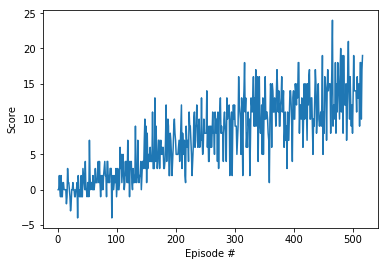

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()